In [499]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pandas import Series
from matplotlib import pyplot
plt.style.use('ggplot')
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

#### Import files for running back statistics and vitals from each player

In [500]:
bs = pd.read_csv('../Final Project/Basic_Stats.csv')
rb = pd.read_csv('../Final Project/Game_Logs_Runningback 2.csv')

#### Remove stats from before 1980. Considering this the modern era of football.

In [501]:
rb = rb.loc[(rb.Year > 1979)]
# rb.Year.sort_values().head(2)

#### Merge stats with player vitals

In [502]:
bs = bs.set_index(['Player Id'])
rb = rb.set_index(['Player Id'])

In [503]:
rb = rb.merge(bs)

#### Search for then select the player you are interested in evaluating. This will narrow our dataframe and make the below cleanup run faster

In [504]:
# search for a player's exact name. some are hard to spell
search_player = 'Bell'
search = rb[rb['Name'].str.contains(search_player)]
search.Name.unique()

array(['Bell, Nick', "Bell, Le'Veon", 'Bell, Richard', 'Bell, Ken',
       'Bell, Tatum', 'Bell, Ricky', 'Bell, Joique', 'Bell, William',
       'Bell, Kahlil', 'Bell, Cameron', 'Bell, Greg', 'Bell, Mike'], dtype=object)

In [505]:
evaluate_player = 'Bell, Joique'
evaluate_metric = 'Rushing Yards'
eval = rb.loc[(rb['Name']==evaluate_player) & (rb['Season'] == 'Regular Season')]

#### Clean Up Data

In [506]:
# drop unnecessary columns
eval = eval.drop(['Birth Place',
 'Birthday','High School',
 'High School Location',
 'Number','Years Played','Experience','Current Status','Current Team','Age'], axis=1, inplace=False)

In [507]:
# fix empty data and numeric issues
eval = eval.replace('--',0)
eval['Longest Rushing Run'] = eval['Longest Rushing Run'].map(lambda x: str(x).rstrip('T'))
eval['Longest Reception'] = eval['Longest Reception'].map(lambda x: str(x).rstrip('T'))
eval = eval.apply(pd.to_numeric, errors='ignore')

In [508]:
# create a timestamp as the index and make sure year is included and correctly sorted
eval["Game Date"] = eval["Game Date"].map(str) + "/" + eval["Year"].map(str)
# dont run this code more than once. if you need to rerun this, rerun all cells before

In [509]:
eval["Game Date"] = pd.to_datetime(eval["Game Date"])
eval_time = eval
eval_time = eval_time.set_index('Game Date')
eval_time = eval_time.sort_index()

In [510]:
# create a column with player experience
# need to create a rookie year column to this most efficiently. then we drop it.
def get_rookie_year(name):
   rookie_year = eval_time.loc[eval_time['Name'] == name, 'Year'].min()
   return rookie_year

eval_time['Rookie Year'] = eval_time.apply(lambda x:get_rookie_year(x['Name']),axis=1)
eval_time['Experience'] = eval_time['Year'] - eval_time['Rookie Year']
eval_time = eval_time.drop(['Rookie Year'], axis=1, inplace=False)

In [511]:
# make consistent numeric datatype
int_cols = ['Year', 
            'Week', 
            'Games Played', 
            'Games Started', 
            'Rushing Attempts', 
            'Rushing Yards', 
            'Longest Rushing Run', 
            'Rushing TDs', 
            'Receptions', 
            'Receiving Yards', 
            'Longest Reception', 
            'Receiving TDs', 
            'Fumbles', 
            'Fumbles Lost',
            'Experience']
for col in int_cols:
    eval_time[col] = eval_time[col].astype(float)

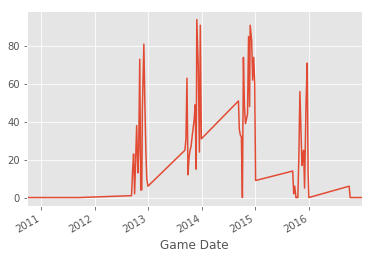

In [512]:
eval_graph = eval_time[evaluate_metric]
eval_graph.plot()
pyplot.show()

In [513]:
# eval_graph

In [514]:
# split datasets into train and test
split_point =len(eval_time[evaluate_metric]) - (len(eval_time[evaluate_metric])/2)
train, test = eval_time[evaluate_metric][0:split_point], eval_time[evaluate_metric][split_point:]
print('Train %d, Test %d' % (len(train), len(test)))

Train 43, Test 43


In [515]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# create inverted differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [516]:
# use difference function to de-seasonalize
x=eval_time[evaluate_metric].values.astype(float)
differenced = difference(x, 12)
len(differenced)

74

In [517]:
# fit model
model = ARIMA(differenced, order=(5,0,1))
model_fit = model.fit(disp=0)
# print("Mean absolute error: ", mean_absolute_error(test, train))
print(model_fit.summary())

/Users/jwujciak/miniconda/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   74
Model:                     ARMA(5, 1)   Log Likelihood                -361.487
Method:                       css-mle   S.D. of innovations             31.512
Date:                Tue, 03 Oct 2017   AIC                            738.974
Time:                        14:58:08   BIC                            757.406
Sample:                             0   HQIC                           746.327
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1606      8.732      0.133      0.895     -15.954      18.275
ar.L1.y       -0.5735      0.116     -4.952      0.000      -0.801      -0.347
ar.L2.y        0.3438      0.131      2.631      0.0

In [518]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=34)[0]
# invert the differenced forecast to something usable
history = [y for y in x]
game = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 12)
    # print('Game %d: %f' % (game, inverted))
    history.append(inverted)
    game += 1

In [519]:
hist = list(history)
df_hist = pd.DataFrame(hist, columns=['proj_rush_yrds'])
forecasts = len(df_hist)-34
df_hist = df_hist[forecasts:]
df_hist = df_hist.reset_index(drop=True)
df_hist.count()

proj_rush_yrds    34
dtype: int64

In [520]:
forecast_game_dates = ['2016-01-01','2016-09-11','2016-09-18','2016-09-25','2016-10-02','2016-10-09','2016-10-16','2016-10-23', '2016-10-30', '2016-11-06', '2016-11-13', '2016-11-20', '2016-11-27', '2016-12-04', '2016-12-11', '2016-12-18', '2016-12-25',
                      '2017-01-01','2017-09-10','2017-09-17','2017-09-24', '2017-10-01', '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29', '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26', '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24'] # padding
# create a list of the dates of the 2016 and 2017 games that we test on and will project to
# forecast_game_dates

In [521]:
df_dates = pd.DataFrame(forecast_game_dates, columns=['game_date'])
df_dates.count()

game_date    34
dtype: int64

In [522]:
df_forecast = df_hist.join(df_dates).set_index('game_date')

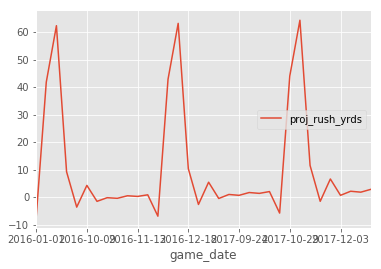

In [523]:
df_forecast.plot()

In [524]:
given = eval_graph.reset_index()
predicted = df_forecast.reset_index()
given.head()

,Game Date,Rushing Yards
0,2010-09-26,0.0
1,2010-10-03,0.0
2,2010-10-10,0.0
3,2010-10-17,0.0
4,2010-10-24,0.0


In [525]:
# df_forecast

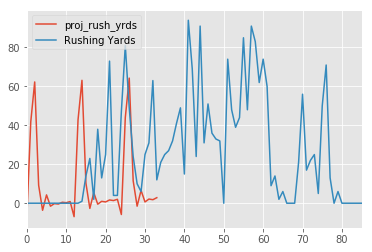

In [528]:
ax = predicted.plot()
given.plot(ax=ax)
pyplot.show()